In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as Fun
import math
from matplotlib import pyplot as plt

from sklearn.model_selection import KFold

In [2]:
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Load traces

In [3]:
def load_traces(data_path, nrows=None, shuffle=False):
    traces = pd.read_csv(data_path, nrows=nrows)

    if shuffle:
        traces = traces.sample(frac=1)

    # Split the data into training and testing sets
    dataset_length = len(traces)
    train_data = traces[:3*int(dataset_length/4)]
    test_data = traces[3*int(dataset_length/4):]

    return train_data, test_data

In [4]:
traces_file = '../traces/trace-omnetpp-5mb.csv'
traces = pd.read_csv(traces_file)
dataset_length = len(traces)
print('number of traces: ', dataset_length)

train_data, test_data = load_traces(traces_file, shuffle=False)
print(train_data[0:100])
print(test_data[0:100])
print(len(train_data))

number of traces:  1419938
    pc  delta_in  delta_out
0    0         0        151
1    0       151          1
2    0         1         20
3    0        20       -171
4    0      -171        172
..  ..       ...        ...
95   0         1          1
96   0         1          1
97   0         1          1
98   0         1          1
99   0         1          1

[100 rows x 3 columns]
         pc  delta_in  delta_out
1064952   0         1        466
1064953   0       466          1
1064954   0         1        437
1064955   0       437         -9
1064956   0        -9          1
...      ..       ...        ...
1065047   0        11          1
1065048   0         1          1
1065049   0         1          1
1065050   0         1          1
1065051   0         1        784

[100 rows x 3 columns]
1064952


In [5]:
batch_size = 256
sequence_length = 64
target_length = 10

# K-fold cross-validation parameters
n_splits = 5  # Number of splits for cross-validation
kf = KFold(n_splits=n_splits, shuffle=False)  # Initialize KFold

### Create vocabulary

In [6]:
# Cuda details should not be part of dataset.
label_encoder_pc = LabelEncoder()
label_encoder_deltas = LabelEncoder()
class PrefetchingDataset(Dataset):
    def __init__(self, pc, delta_in):
        #self.targets = targets
        self.delta_in = label_encoder_deltas.transform(delta_in)
        self.pcs = pc
       
    
    def __len__(self):
        return (int(batch_size * math.floor(len(self.delta_in)/batch_size)) - batch_size)

    def __getitem__(self, idx):
        #pcs = Fun.one_hot(torch.tensor(self.pcs[idx:idx+sequence_length]), max(num_pc, num_output_next))
        #deltas = Fun.one_hot(torch.tensor(self.delta_in[idx:idx+sequence_length]), max(num_pc, num_output_next))
        #pcs = torch.tensor(self.pcs[idx:idx+sequence_length])
        pcs = self.pcs[idx:idx+sequence_length]
        deltas = torch.tensor(self.delta_in[idx:idx+sequence_length])
        
        targets = Fun.one_hot(torch.tensor(self.delta_in[idx+sequence_length]), num_output_next)
    
        
        return (pcs, deltas, targets)

def load_data(data, batch_size):
    data = data.copy()
    deltas = data['delta_in']
    # Modify the DataFrame safely
    data.loc[:, 'pc_encoded'] = label_encoder_pc.transform(data['pc'].values)
    pc = torch.tensor(data['pc_encoded'].values)
    dataset = PrefetchingDataset(pc, deltas)
    print("Dataset:", len(dataset))
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    # Get unique target keys
    target_keys = set(deltas.unique())
    print("Data loader", len(data_loader))
    return data_loader, len(label_encoder_pc.classes_), len(label_encoder_deltas.classes_), len(label_encoder_deltas.classes_), target_keys



label_encoder_pc.fit(list(set().union(train_data['pc'].values, test_data['pc'].values)))
label_encoder_deltas.fit(list(set().union(train_data['delta_in'].values, test_data['delta_in'].values)))
train_iter, num_pc, num_delta_in, num_output_next, target_keys = load_data(train_data, batch_size=batch_size)
test_iter, _, _, _, _ = load_data(test_data, batch_size=batch_size)
# add 1 for the next delta which is not in the training set
num_pc += 1
num_delta_in += 1
num_output_next += 1
print("Train iter:", len(train_iter))
print('number of unique pc: ', num_pc)
print('number of unique input delta: ', num_delta_in)
print('number of unique output delta: ', num_output_next)


Dataset: 1064448
Data loader 4158
Dataset: 354560
Data loader 1385
Train iter: 4158
number of unique pc:  2
number of unique input delta:  2562
number of unique output delta:  2562


1064952
5 highest bins: [491944. 154277.  33708.  33523.]
  their ranges: [(0.0, 100.0), (-100.0, 0.0), (100.0, 200.0), (-200.0, -100.0)]


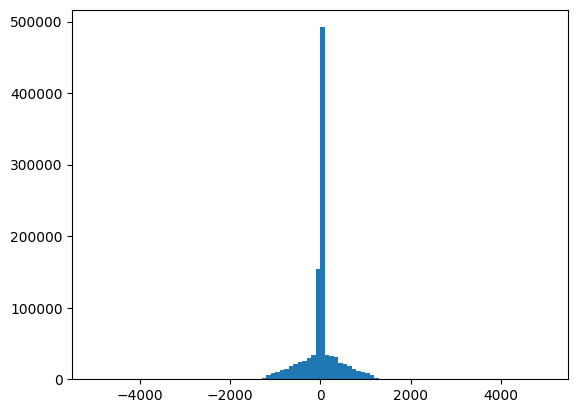

In [7]:
# Histogram of the data.
values, bins, patches = plt.hist(train_data['delta_in'], bins=100, range=[-5000, 5000])
order = np.argsort(values)[::-1]
print(len(train_data['delta_in']))
print("5 highest bins:", values[order][:4])
print("  their ranges:", [ (bins[i], bins[i+1])   for i in order[:4]])

plt.show()

In [8]:
_, cts = np.unique(train_data['delta_in'], axis=0, return_counts=True)
len(np.where(cts < 10)[0])

25

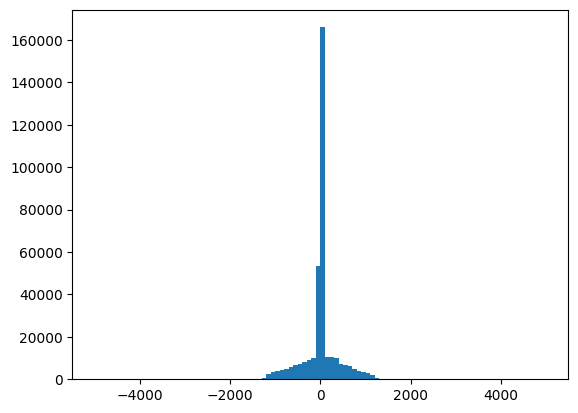

In [9]:
plt.hist(test_data['delta_in'], bins=100, range=[-5000,5000])
plt.show()

### Define LSTM model

In [10]:
class EmbeddingLSTM(nn.Module):
    def __init__(self, num_pc, num_delta_in, num_output_next, embed_dim, hidden_dim, output_dim, topPredNum, num_layers, dropout):
        # Layer structure is described in the paper
        super(EmbeddingLSTM, self).__init__()
        self.topPredNum = topPredNum
        # Define embedding layers
        # TODO(yisheng): Num_pc should be the input history size.
        self.pc_embed_layer = nn.Embedding(num_pc, embed_dim)
        # TODO(yisheng): Num_pc and num_delta will be the same
        self.delta_embed_layer = nn.Embedding(num_delta_in, embed_dim)
        # Define LSTM layer
        # LSTM input dimension: (pc_embed + delta_embed) * 2
        # What does concat mean? and dimension should be the same as embed_dim
        lstm_input_dim = embed_dim
        self.lstm = nn.LSTM(lstm_input_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        # Define output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        # Define dropout layer
        # TODO: why is this needed?
        self.dropout = nn.Dropout(p=dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, h_c_state, target=None):
        pc, delta = x
        pc_embed = self.pc_embed_layer(pc)
        delta_embed = self.delta_embed_layer(delta)
        #pc_delta_embed_out = torch.cat([pc_embed, delta_embed], dim = -1).to(torch.float32)
        lstm_out, (h_0, c_0) = self.lstm(delta_embed, h_c_state)
        # lstm_out shape: (batch_size, seq_len, hidden_dim)
        #outputs = self.fc(lstm_out)
        state = (h_0, c_0)
        # out = h_0[-1]
        #out_dropout = self.dropout(h_0[-1])
        out = self.fc(h_0[-1])
        
        #out = self.sigmoid(out)
        if target is not None:
            loss = nn.CrossEntropyLoss()(out, target.to(torch.float32)) 
        else:
            loss = None
        
        # Get top k predictions
        _, preds = torch.topk(out, self.topPredNum, sorted=False)
        return preds, state, loss

    def predict(self, X, lstm_state):
        with torch.no_grad():
            preds, state, _ = self.forward(X, lstm_state)
            return preds, state



### Tune hyperparameters here

In [11]:
# Set up hyperparameters
hparams = {
    "topPredNum": 10,
    "embed_dim": 128,
    "hidden_dim": 128,
    "output_dim": num_output_next,
    "num_layers": 2,
    "dropout": 0.1,
    "learning_rate": 0.001,
    "epochs": 10
}

In [12]:
def validate_model(network, data_iterator, relevant_keys, computing_device="cpu", initial_state=None):
    network.eval()

    accuracy_metrics = [process_batch(i, batch_data, network, computing_device, initial_state, relevant_keys) 
                        for i, batch_data in enumerate(data_iterator)]

    average_accuracy = torch.tensor(accuracy_metrics).mean()
    print("Average Validation Accuracy: {:.4f}".format(average_accuracy))
    return average_accuracy

def process_batch(batch_index, batch_data, network, device, state, keys):
    print(f"Processing batch {batch_index}")

    batch_data = [item.to(device) for item in batch_data]
    input_data = batch_data[:-1]
    labels = batch_data[-1]
    labels = torch.argmax(labels, dim = 1)
    
    predictions, state = network.predict(input_data, state)
    accuracy = compute_accuracy(predictions, labels, keys)

    return accuracy

def compute_accuracy(predictions, labels, keys):
    combined_data = list(zip(labels, predictions))
    count_correct = sum([1 for label, predicted in combined_data 
                         if label.item() in keys and label in predicted])
    
    return count_correct / len(labels)

### Train the model

In [13]:

fold_metrics = []

# Loop over each fold
for fold, (train_idx, test_idx) in enumerate(kf.split(np.arange(dataset_length))):
    print(f"Fold {fold + 1}/{n_splits}")

    # Split the dataset
    train_data, test_data = traces.iloc[train_idx], traces.iloc[test_idx]

    # DataLoader for train and test sets
    train_iter, _, _, _, _ = load_data(train_data, batch_size=batch_size)
    test_iter, _, _, _, _ = load_data(test_data, batch_size=batch_size)

    # Initialize the model for the current fold
    my_model = EmbeddingLSTM(
        num_pc,
        num_delta_in,
        num_output_next,
        hparams["embed_dim"],
        hparams["hidden_dim"],
        hparams["output_dim"],
        topPredNum=hparams["topPredNum"],
        num_layers=hparams["num_layers"],
        dropout=hparams["dropout"]
    ).to(device)

    # Prepare for training
    train_loss = []
    optimizer = torch.optim.Adam(my_model.parameters(), lr=hparams["learning_rate"])

    # Start training for the current fold
    for epoch in range(hparams["epochs"]):
        my_model.train()
        h_0 = torch.zeros(hparams["num_layers"], batch_size, hparams["hidden_dim"]).to(device)
        c_0 = torch.zeros(hparams["num_layers"], batch_size, hparams["hidden_dim"]).to(device)
        lstm_state = (h_0, c_0)

        for idx, batch in enumerate(train_iter):
            batch = [ds.to(device) for ds in batch]
            inputs = batch[:-1]
            targets = batch[-1]
            optimizer.zero_grad()
            _, lstm_state, batch_loss = my_model(inputs, lstm_state, targets)
            batch_loss.backward()
            optimizer.step()
            train_loss.append(float(batch_loss.item()))
            if idx % 1000 == 0:
                print(f"Fold {fold + 1}, Epoch {epoch + 1}, Iteration {idx}, Loss: {train_loss[-1]:.8f}")
            lstm_state = tuple([s.data for s in lstm_state])

    # Evaluate the model on the test set for the current fold
    fold_accuracy = validate_model(my_model, test_iter, target_keys, computing_device=device)
    fold_metrics.append(fold_accuracy)

# Calculate and print average performance across all folds
average_performance = sum(fold_metrics) / len(fold_metrics)
print(f"Average performance over {n_splits} folds: {average_performance}")

Fold 1/5
Dataset: 1135616
Data loader 4436
Dataset: 283648
Data loader 1108
Fold 1, Epoch 1, Iteration 0, Loss: 7.84495211
Fold 1, Epoch 1, Iteration 1000, Loss: 5.27830124
Fold 1, Epoch 1, Iteration 2000, Loss: 5.41904402
Fold 1, Epoch 1, Iteration 3000, Loss: 5.50178957
Fold 1, Epoch 1, Iteration 4000, Loss: 5.80617476
Fold 1, Epoch 2, Iteration 0, Loss: 5.37922001
Fold 1, Epoch 2, Iteration 1000, Loss: 4.92604733
Fold 1, Epoch 2, Iteration 2000, Loss: 5.23601389
Fold 1, Epoch 2, Iteration 3000, Loss: 5.19928360
Fold 1, Epoch 2, Iteration 4000, Loss: 5.67208385
Fold 1, Epoch 3, Iteration 0, Loss: 5.22698784
Fold 1, Epoch 3, Iteration 1000, Loss: 4.69172287
Fold 1, Epoch 3, Iteration 2000, Loss: 5.01213264
Fold 1, Epoch 3, Iteration 3000, Loss: 4.99540472
Fold 1, Epoch 3, Iteration 4000, Loss: 5.50345755
Fold 1, Epoch 4, Iteration 0, Loss: 5.13034344
Fold 1, Epoch 4, Iteration 1000, Loss: 4.59305382
Fold 1, Epoch 4, Iteration 2000, Loss: 4.90501738
Fold 1, Epoch 4, Iteration 3000, Los

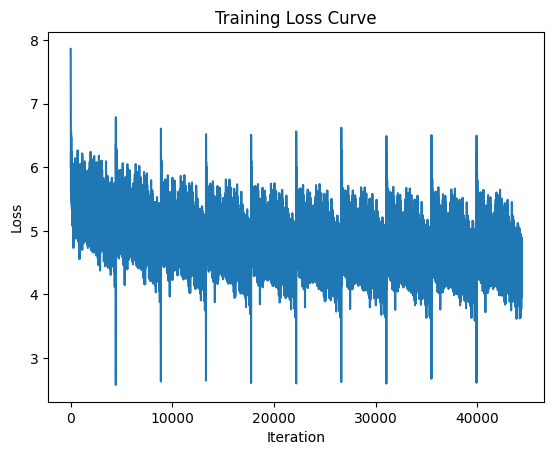

In [14]:
plt.plot(train_loss)
plt.title("Training Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

### Validate the model